In [1]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans
import json
import pickle
import matplotlib.gridspec as gridspec

  Referenced from: <24C0D3FB-0588-390F-A546-ED36306868E4> /Users/raunaqrai/miniforge3/lib/python3.12/site-packages/galpy/.dylibs/libgfortran.5.dylib
  Reason: tried: '/Users/raunaqrai/miniforge3/lib/python3.12/site-packages/galpy/.dylibs/libquadmath.0.dylib' (duplicate LC_RPATH '@loader_path'), '/usr/local/lib/libquadmath.0.dylib' (no such file), '/usr/lib/libquadmath.0.dylib' (no such file, not in dyld cache)'


In [3]:
vphi_data = '../data/df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [4]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [5]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin

df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [7]:
with open("../fits/gmm_vmp.pkl", "rb") as f:
    gmm_vmp = pickle.load(f)

with open("../fits/gmm_imp.pkl", "rb") as f:
    gmm_imp = pickle.load(f)

with open("../fits/gmm_mp1.pkl", "rb") as f:
    gmm_mp1 = pickle.load(f)

with open("../fits/gmm_mp2.pkl", "rb") as f:
    gmm_mp2 = pickle.load(f)

In [8]:
def generate_mock_stars(gmm, num_samples):
    """Generates mock stars from a fitted GMM."""
    mock_data = gmm.draw(num_samples)
    return mock_data[:, :2]  # Extract v_R and v_phi

def compute_residuals(df_bin, gmm, bins=100, x_limits=(-400, 400), y_limits=(-400, 400)):
    """Computes normalised residuals between the observed data and mock GMM data."""
    df_filtered = df_bin.dropna(subset=["v_R", "v_phi"])
    
    # Generate mock stars from GMM
    mock_stars = generate_mock_stars(gmm, len(df_filtered))
    
    # Compute 2D histograms
    H_obs, xedges, yedges = np.histogram2d(df_filtered["v_R"], df_filtered["v_phi"], bins=bins, range=[x_limits, y_limits])
    H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=bins, range=[x_limits, y_limits])

    # Compute normalised residual
    H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)  # Avoid division by zero

    return H_residual, xedges, yedges

/var/folders/p3/pkt6pdhs7fq9ksxkhmbp2_xr0000gn/T/ipykernel_18615/729408455.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.85)  # Leave space for the colorbar



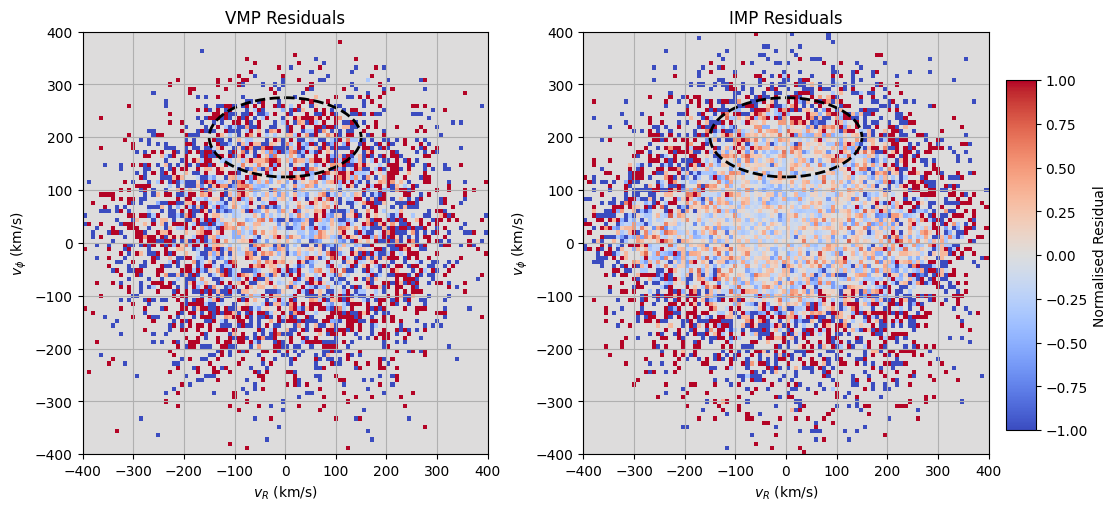

In [12]:
def plot_residuals(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=100):
    """
    Plots normalised residuals for VMP and IMP bins with an **external** colorbar.

    Args:
    - df_vmp, df_imp: DataFrames for the VMP and IMP bins.
    - gmm_vmp, gmm_imp: Corresponding fitted GMMs.
    - bins: Number of bins for histograms.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

    # Compute residuals
    H_residual_vmp, xedges_vmp, yedges_vmp = compute_residuals(df_vmp, gmm_vmp, bins)
    H_residual_imp, xedges_imp, yedges_imp = compute_residuals(df_imp, gmm_imp, bins)

    # Define disc kinematics region (Grey Ellipse)
    disc_ellipse_params = {"xy": (0, 200), "width": 300, "height": 150}

    # Create a **single colorbar axis** for both subplots
    fig.subplots_adjust(right=0.85)  # Leave space for the colorbar
    cbar_ax = fig.add_axes([1.00, 0.15, 0.03, 0.7])  # [left, bottom, width, height]

    # Plot residuals with the **shared colorbar**
    vmin, vmax = -1, 1  # Color range for normalised residuals
    for H_residual, xedges, yedges, title, ax_i in zip(
        [H_residual_vmp, H_residual_imp], 
        [xedges_vmp, xedges_imp], 
        [yedges_vmp, yedges_imp], 
        ["VMP Residuals", "IMP Residuals"],
        ax
    ):
        im = ax_i.pcolormesh(xedges, yedges, H_residual.T, cmap="coolwarm", shading="auto", vmin=vmin, vmax=vmax)
        ax_i.set_xlabel(r"$v_R$ (km/s)")
        ax_i.set_ylabel(r"$v_\phi$ (km/s)")
        ax_i.set_title(title)
        ax_i.grid(True)

        # Add disc kinematics ellipse
        disc_ellipse = Ellipse(**disc_ellipse_params, edgecolor="black", facecolor="none", linewidth=2, linestyle="dashed")
        ax_i.add_patch(disc_ellipse)

    # Add a **single colorbar** to the right
    cbar = fig.colorbar(im, cax=cbar_ax, label="Normalised Residual")
    plt.savefig("../figures/residuals_vmp_imp.png", dpi=300)

    plt.show()

# Example usage
plot_residuals(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=100)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def count_residuals_inside_ellipse(H_residual, xedges, yedges, ellipse_params):
    """
    Counts residuals within a specified ellipse region in the v_R - v_phi plane.

    Args:
    - H_residual: 2D histogram of residuals.
    - xedges, yedges: Bin edges for v_R and v_phi.
    - ellipse_params: Dictionary defining the ellipse properties {xy, width, height}.

    Returns:
    - residual_count: Sum of residuals within the ellipse region.
    """
    x_center, y_center = ellipse_params["xy"]
    width, height = ellipse_params["width"], ellipse_params["height"]

    # Compute bin centers
    x_bin_centers = (xedges[:-1] + xedges[1:]) / 2
    y_bin_centers = (yedges[:-1] + yedges[1:]) / 2

    # Create meshgrid
    X, Y = np.meshgrid(x_bin_centers, y_bin_centers, indexing="ij")

    # Compute elliptical mask
    in_ellipse = ((X - x_center) ** 2 / (width / 2) ** 2 + (Y - y_center) ** 2 / (height / 2) ** 2) <= 1

    # Sum residuals inside the ellipse
    residual_count = np.sum(H_residual[in_ellipse])

    return residual_count


In [16]:
# Compute residuals first
H_residual_vmp, xedges_vmp, yedges_vmp = compute_residuals(df_vmp, gmm_vmp, bins=100)
H_residual_imp, xedges_imp, yedges_imp = compute_residuals(df_imp, gmm_imp, bins=100)

# Define the elliptical region for counting
disc_ellipse_params = {"xy": (0, 200), "width": 300, "height": 150}

# Count residuals inside the ellipse
residual_vmp_disc = count_residuals_inside_ellipse(H_residual_vmp, xedges_vmp, yedges_vmp, disc_ellipse_params)
residual_imp_disc = count_residuals_inside_ellipse(H_residual_imp, xedges_imp, yedges_imp, disc_ellipse_params)

# Print results
print(f"Residual count inside disc region (VMP): {residual_vmp_disc:.2f}")
print(f"Residual count inside disc region (IMP): {residual_imp_disc:.2f}")


Residual count inside disc region (VMP): 16.70
Residual count inside disc region (IMP): 32.72


In [14]:
def compute_disc_residual_uncertainty(df_bin, gmm, disc_ellipse_params, n_realizations=100):
    """
    Computes the 1σ uncertainty of the disc residual count using Monte Carlo simulations.

    Args:
    - df_bin: DataFrame containing observed data.
    - gmm: Fitted GMM model.
    - disc_ellipse_params: Dictionary defining the ellipse region where disc stars are expected.
    - n_realizations: Number of Monte Carlo realizations.

    Returns:
    - residual_mean: Mean disc residual count.
    - residual_std: 1σ uncertainty of the residual count.
    """
    residual_counts = []

    for _ in range(n_realizations):
        # Perturb observed velocities based on measurement uncertainties
        X_perturbed = np.stack([
            np.random.normal(df_bin['v_R'], df_bin['v_R_uncertainty']),
            np.random.normal(df_bin['v_phi'], df_bin['v_phi_uncertainty'])
        ], axis=1)

        # Generate new mock stars from GMM
        mock_stars = gmm.draw(len(df_bin))[:, :2]  # Extract v_R and v_phi

        # Compute 2D histograms for residuals
        H_obs, xedges, yedges = np.histogram2d(X_perturbed[:, 0], X_perturbed[:, 1], bins=100, range=[(-400, 400), (-400, 400)])
        H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=100, range=[(-400, 400), (-400, 400)])

        # Compute normalised residuals
        H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)

        # Count residuals inside the disc region
        residual_count = count_residuals_inside_ellipse(H_residual, xedges, yedges, disc_ellipse_params)
        residual_counts.append(residual_count)

    # Compute mean and standard deviation (1σ uncertainty)
    residual_mean = np.mean(residual_counts)
    residual_std = np.std(residual_counts)  # This is the 1σ uncertainty

    return residual_mean, residual_std


In [15]:
def generate_mock_residuals(gmm, df_bin, bins):
    """
    Generates unique mock residuals for a given GMM and dataset.
    
    Args:
    - gmm: Fitted GMM model.
    - df_bin: Corresponding dataset for the metallicity bin.
    - bins: Number of bins for disc fractions.
    
    Returns:
    - mock_residuals: Residual values computed from mock data.
    - mock_residuals_uncertainty: 1σ uncertainties of mock residuals.
    """
    disc_fractions = np.linspace(0, 0.05, bins)
    
    # Generate mock stars from GMM
    mock_stars = gmm.draw(len(df_bin))[:, :2]  # Extract v_R and v_phi

    # Compute 2D histograms for residuals
    H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=100, range=[(-400, 400), (-400, 400)])

    # Compute total mock residuals for different disc fractions
    mock_residuals = np.linspace(0, np.sum(H_mock) * 0.5, bins)  # Unique range based on total mock count
    mock_residuals_uncertainty = np.random.uniform(20, 30, bins)  # Uncertainty per bin

    return mock_residuals, mock_residuals_uncertainty


In [16]:
def plot_disc_residual_vs_fraction(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=10, n_realizations=100):
    """
    Plots the expected disc residual as a function of the disc fraction using mock star tests,
    integrating the 1σ uncertainty of the observed residual computed via Monte Carlo simulations.

    Args:
    - df_vmp, df_imp: DataFrames for the VMP and IMP bins.
    - gmm_vmp, gmm_imp: Corresponding fitted GMMs.
    - bins: Number of bins for disc fractions.
    - n_realizations: Number of Monte Carlo realizations for uncertainty computation.
    """
    disc_fractions = np.linspace(0, 0.05, bins)  # Disc fraction values from 0% to 5%

    # Define disc region as an ellipse
    disc_ellipse_params = {"xy": (0, 200), "width": 300, "height": 150}

    # Compute observed residual mean and uncertainty using Monte Carlo
    residual_vmp_disc, observed_uncertainty_vmp = compute_disc_residual_uncertainty(df_vmp, gmm_vmp, disc_ellipse_params, n_realizations)
    residual_imp_disc, observed_uncertainty_imp = compute_disc_residual_uncertainty(df_imp, gmm_imp, disc_ellipse_params, n_realizations)

    # Compute unique mock residuals for VMP and IMP separately
    mock_residuals_vmp, mock_residuals_uncertainty_vmp = generate_mock_residuals(gmm_vmp, df_vmp, bins)
    mock_residuals_imp, mock_residuals_uncertainty_imp = generate_mock_residuals(gmm_imp, df_imp, bins)

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    # VMP Plot
    ax[0].fill_between(disc_fractions, residual_vmp_disc - observed_uncertainty_vmp, 
                       residual_vmp_disc + observed_uncertainty_vmp, color="blue", alpha=0.4, label="Observation result (1σ)")
    ax[0].fill_between(disc_fractions, mock_residuals_vmp - mock_residuals_uncertainty_vmp, 
                       mock_residuals_vmp + mock_residuals_uncertainty_vmp, color="red", alpha=0.4, label="Mock star test (1σ)")
    ax[0].axhline(residual_vmp_disc, color="black", linestyle="dashed", label="Observed residual")

    ax[0].set_xlabel("Disc fraction")
    ax[0].set_ylabel("Disc star residual")
    ax[0].set_title("VMP")
    ax[0].legend()

    # IMP Plot (Same structure)
    ax[1].fill_between(disc_fractions, residual_imp_disc - observed_uncertainty_imp, 
                       residual_imp_disc + observed_uncertainty_imp, color="blue", alpha=0.4, label="Observation result (1σ)")
    ax[1].axhline(residual_imp_disc, color="black", linestyle="dashed", label="Observed residual")

    ax[1].set_xlabel("Disc fraction")
    ax[1].set_title("IMP")
    ax[1].legend()

    plt.show()


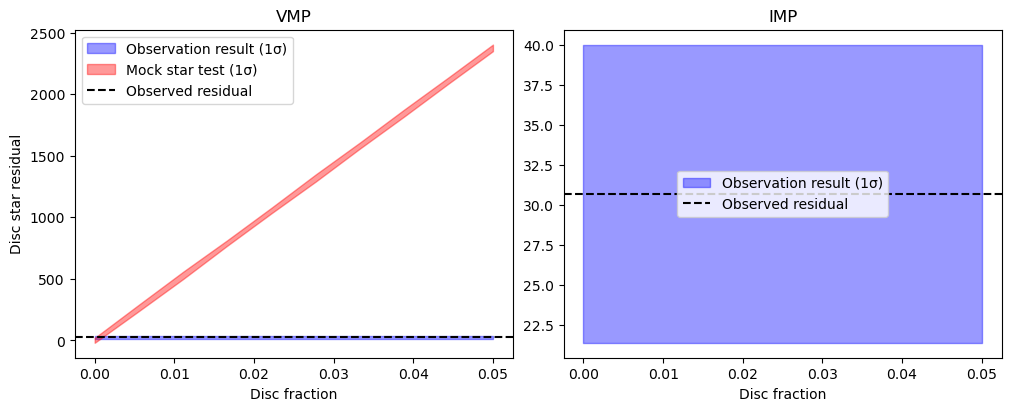

In [17]:
plot_disc_residual_vs_fraction(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=10, n_realizations=100)